## Thomas Sampling algorithm in non-stationary environment

We work with a simple case of non-stationary environment. The time horizon is divided in phases of equal size. In each phase the mean of each arm changes. A non-stationary environmentis an environment in which the arms reward functions are dependent from the current time. We need to specify, for each arm, a reward function which is dependent from the current time. We will define this class as an extension of te Environment class.

In [ ]:
import numpy as np

In [ ]:
class Environment():

  def __init__(self,n_arms,probabilities):
    self.n_arms = n_arms
    self.probabilities = probabilities  # we will use bernoullian distributions (represented by one value of each arm)

  # function to model the interaction with the learner
  def round_(self, pulled_arm):
    reward = np.random.binomial(1,self.probabilities[pulled_arm])
    return reward

In [ ]:
class Non_Stationary_Environment(Environment):
  def __init__(self, n_arms, probabilities, horizon):   # the probabilities will be a list of probabilities, one for each phase
    super().__init__(n_arms,probabilities)
    self.t = 0
    n_phases = len(self.probabilities)
    self.phases_size = horizon/n_phases

  # override round method
  def round_(self,pulled_arm):
    current_phase = int(self.t / self.phases_size)
    p = self.probabilities[current_phase][pulled_arm]
    reward = np.random.binomial(1,p)
    self.t += 1
    return reward

We proceed with the Sliding Window Thompson Sampling algorithm. The SWTS-Learber exploits a sliding window to use only recent observations to update the beta distribution parameters. We will define this class as an extension of the TS-Learner.

In [ ]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each rounds

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

class TS_Learner(Learner):
  def __init__(self,n_arms):
    super().__init__(n_arms)
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions

  def pull_arm(self):
    idx = np.argmax(np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1]))
    return idx

  # update parameters each time a reward is observed
  def update(self,pulled_arm,reward):
    self.t += 1
    self.update_observations(pulled_arm,reward)
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1.0 - reward

In [ ]:
class SWTS_Learner(TS_Learner):
  def __init__(self,n_arms,window_size):
    super().__init__(n_arms)
    self.window_size = window_size   # size of the window in which we consider the samples to update the paraemeters
    self.pulled_arms = np.array([])  # to keep track of the pulled arms

  def update(self,pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.pulled_arms = np.append(self.pulled_arms,pulled_arm)
    for arm in range(self.n_arms):
      n_samples = np.sum(self.pulled_arms[-self.window_size:] == arm)                           # for the pulled arm, how many samples are in the window
      cum_rew = np.sum(self.rewards_per_arm[arm][-n_samples:]) if n_samples > 0 else 0  # cumulative reward for such samples
      # update beta parameters
      self.beta_parameters[arm,0] = cum_rew + 1.0
      self.beta_parameters[arm,1] = n_samples - cum_rew + 1.0

We then compare TS with the Sliding Window version.

In [ ]:
import matplotlib.pyplot as plt

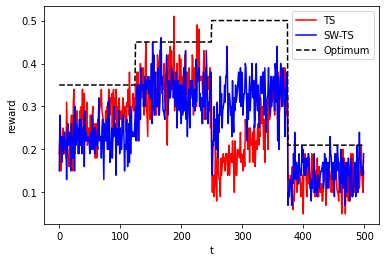

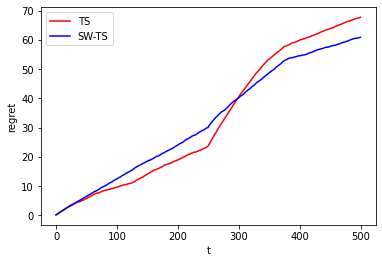

In [ ]:
n_arms = 4
n_phases = 4
p = np.array([[0.15,0.1,0.2,0.35],
              [0.45,0.21,0.2,0.35],
              [0.1,0.1,0.5,0.15],
              [0.1,0.21,0.1,0.15]])
T = 500
phases_len = int(T/n_phases)
n_experiments = 100
ts_rewards_per_experiment = []
swts_rewards_per_experiment = []
window_size = int(T**0.5)   # proportional to sqrt(T)

for e in range(0,n_experiments):       # for each experiment we simulate the environment-learner interaction
  ts_env = Non_Stationary_Environment(n_arms = n_arms, probabilities = p, horizon = T)
  ts_learner = TS_Learner(n_arms = n_arms)

  swts_env = Non_Stationary_Environment(n_arms = n_arms, probabilities = p, horizon = T)
  swts_learner = SWTS_Learner(n_arms = n_arms, window_size = window_size)

  for t in range(T):                # iterate on the number of rounds/horizon and for each iteration simulate the interaction

    # TS
    pulled_arm_ts = ts_learner.pull_arm()
    reward_ts = ts_env.round_(pulled_arm_ts)
    ts_learner.update(pulled_arm_ts,reward_ts)

    # SWTS
    pulled_arm_swts = swts_learner.pull_arm()
    reward_swts = swts_env.round_(pulled_arm_swts)
    swts_learner.update(pulled_arm_swts,reward_swts)

  # store values
  ts_rewards_per_experiment.append(ts_learner.collected_rewards)
  swts_rewards_per_experiment.append(swts_learner.collected_rewards)

# define instantaneous regret and for each phase find out the optimal action
ts_instantaneus_regret = np.zeros(T)
swts_instantaneus_regret = np.zeros(T)
opt_per_phase = p.max(axis = 1)
optimum_per_round = np.zeros(T)

# for each phase define the corresponding time indexes, the instantaneous regret and the mean collected reward in those timesteps
for i in range(n_phases):
  t_index = range(i*phases_len, (i+1)*phases_len)
  optimum_per_round[t_index] = opt_per_phase[i]
  ts_instantaneus_regret[t_index] = opt_per_phase[i] - np.mean(ts_rewards_per_experiment, axis = 0)[t_index]
  swts_instantaneus_regret[t_index] = opt_per_phase[i] - np.mean(swts_rewards_per_experiment, axis = 0)[t_index]

# plot results
plt.figure(0)
plt.xlabel('t')
plt.ylabel('reward')
plt.plot(np.mean(ts_rewards_per_experiment, axis = 0), 'r')
plt.plot(np.mean(swts_rewards_per_experiment, axis = 0), 'b')
plt.plot(optimum_per_round, 'k--')
plt.legend(['TS', 'SW-TS','Optimum'])
plt.show()

plt.figure(1)
plt.xlabel('t')
plt.ylabel('regret')
plt.plot(np.cumsum(np.mean(optimum_per_round - ts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(optimum_per_round - swts_rewards_per_experiment, axis = 0)), 'b')
plt.legend(['TS', 'SW-TS'])
plt.show()

The sliding window, expeciallt in the third phase, is much quicker to converge to the optimal reward.